### 1  Load the Data

We import the necessary libraries and load the **data** sheet from *EastWestAirlines.xlsx*.  
A quick glance at the first few rows confirms the structure.


In [2]:
pip install openpyxl



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

In [3]:
import pandas as pd
import numpy as np

# Path to your file (adjust if the notebook sits elsewhere)
file_path = "EastWestAirlines.xlsx"

# Load the "data" sheet
df = pd.read_excel(file_path, sheet_name="data")

# Basic inspection
print("Shape:", df.shape)
display(df.head())
display(df.info())


Shape: (3999, 12)


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID#                3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award?             3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


None

### 2  Missing‑value Check

We verify if any column contains nulls.  
For this dataset we expect *no* missing values, but we’ll confirm and (if needed) impute or drop rows.


In [4]:
# Count missing values
missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])


Series([], dtype: int64)


### 3  Exploratory Data Analysis (EDA)

We examine distributions, spot potential outliers, and look for correlations that may hint at natural groupings.


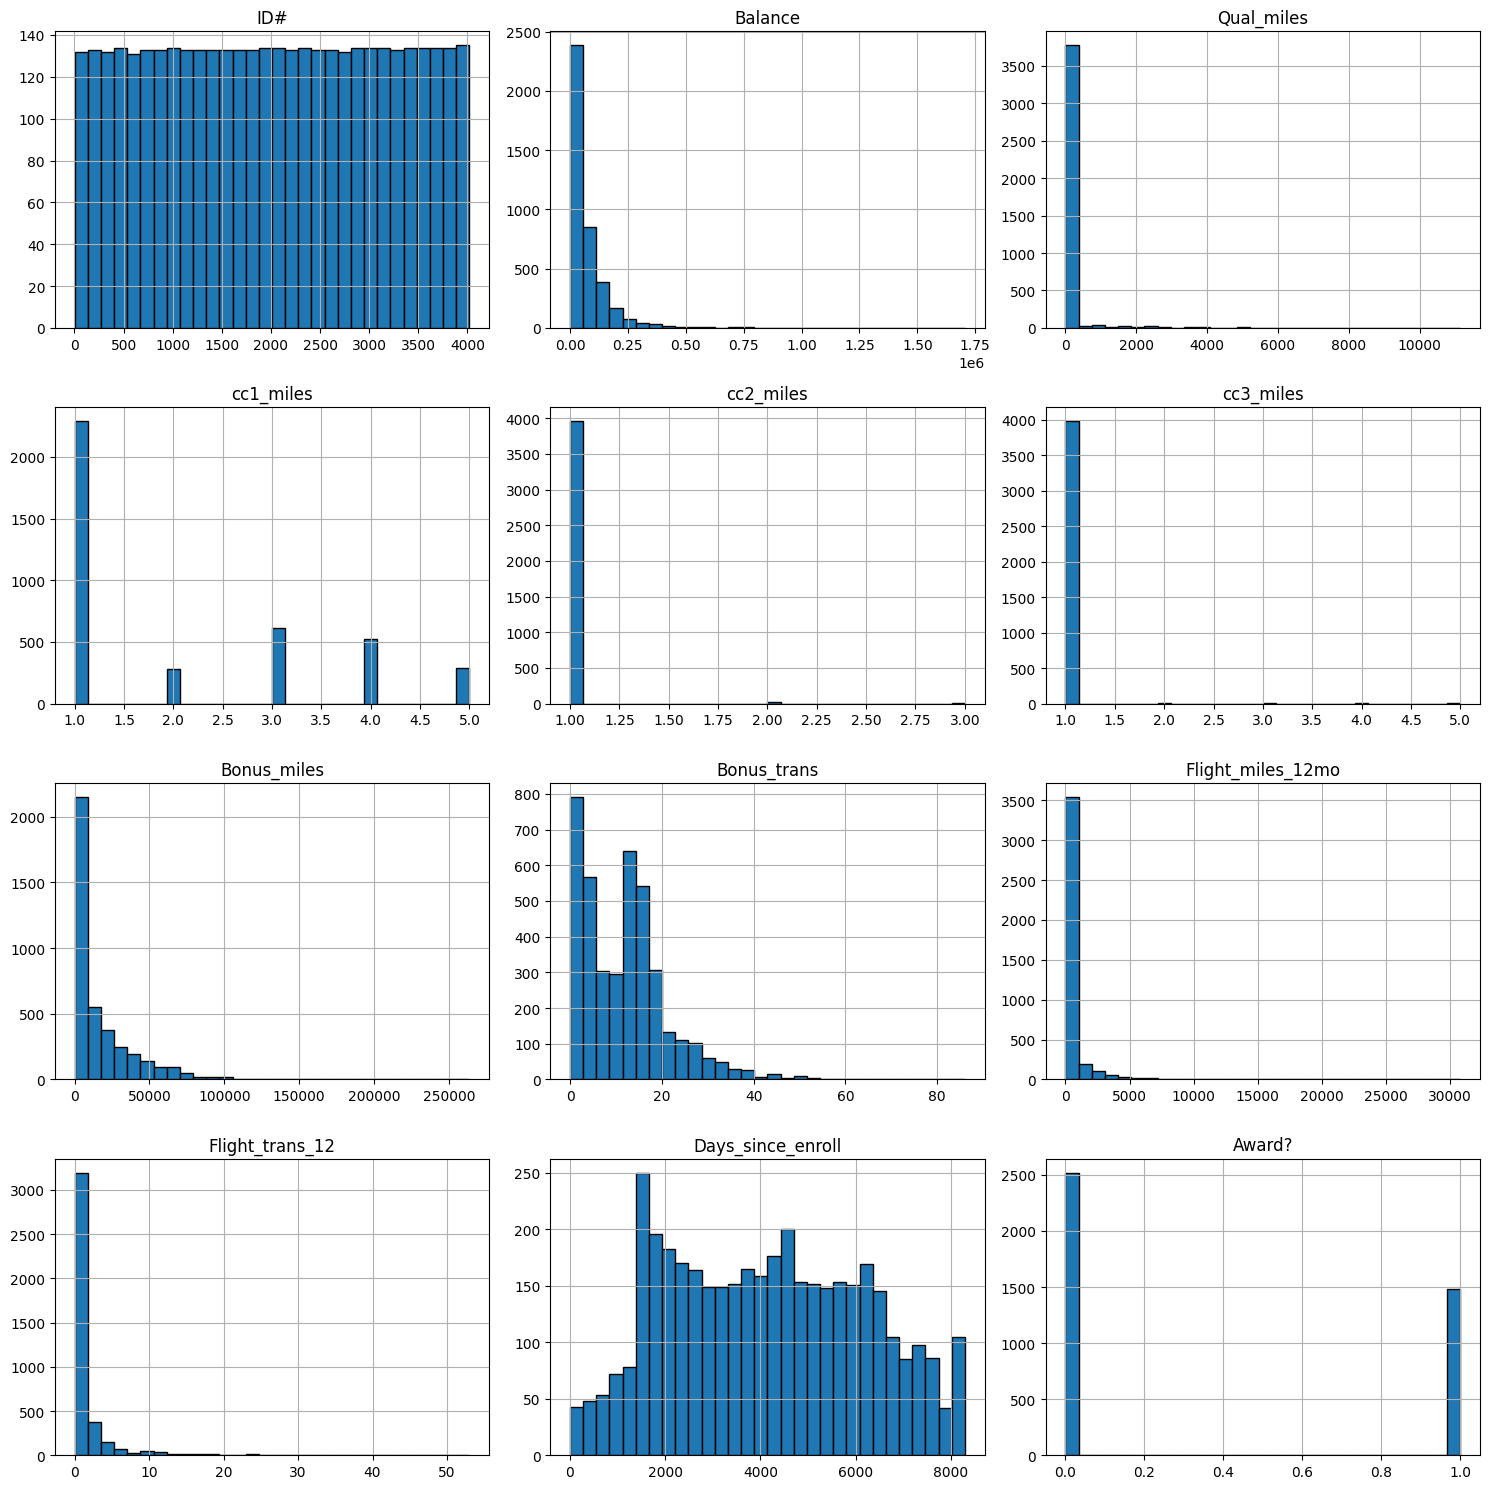

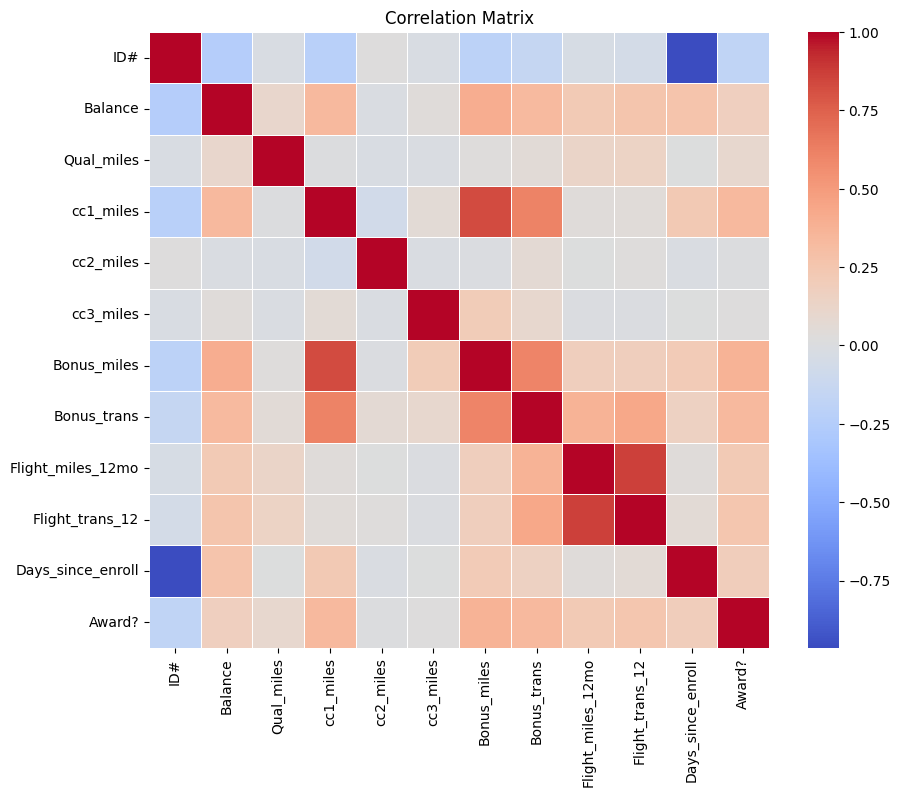

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=np.number).columns

# 3.1 Histograms
df[numeric_cols].hist(figsize=(15, 15), bins=30, edgecolor="k")
plt.tight_layout()
plt.show()

# 3.2 Correlation heat‑map
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


### 4  Outlier Handling

We’ll apply a mild winsorization using 1.5×IQR caps on highly skewed monetary variables.


In [6]:
def winsorize(series, factor=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - factor * iqr, q3 + factor * iqr
    return series.clip(lower, upper)

skewed = ["Balance", "Bonus_miles", "Qual_miles", "Flight_miles_12mo"]
df[skewed] = df[skewed].apply(winsorize)



### 5  Feature Scaling

K‑Means and DBSCAN rely on distance metrics; we’ll use **StandardScaler** on the continuous vars while keeping ID & Award? aside.


In [7]:
from sklearn.preprocessing import StandardScaler

# Preserve ID and target for later interpretation
id_col = df["ID#"]
award = df["Award?"]

X = df.drop(columns=["ID#", "Award?"])  # features only

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a scaled DataFrame for easy inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df.head())


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
0,-0.607258,0.0,-0.769578,-0.098242,-0.062767,-0.843091,-1.104065,-0.604313,-0.362168,1.395454
1,-0.758947,0.0,-0.769578,-0.098242,-0.062767,-0.840822,-0.999926,-0.604313,-0.362168,1.379957
2,-0.382070,0.0,-0.769578,-0.098242,-0.062767,-0.624581,-0.791649,-0.604313,-0.362168,1.411920
3,-0.835106,0.0,-0.769578,-0.098242,-0.062767,-0.825052,-1.104065,-0.604313,-0.362168,1.372208
4,0.579265,0.0,1.409471,-0.098242,-0.062767,1.543191,1.499394,2.034489,0.692490,1.363975


## 2‑A  K‑Means Clustering

We determine an appropriate number of clusters *K* using the **Elbow curve** and **Silhouette score**, then fit the final model and visualize the clusters in 2‑D (PCA).


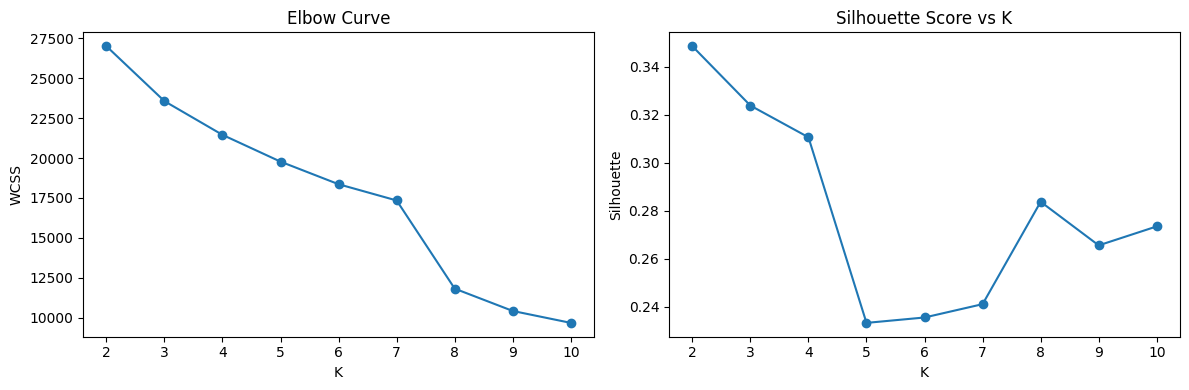

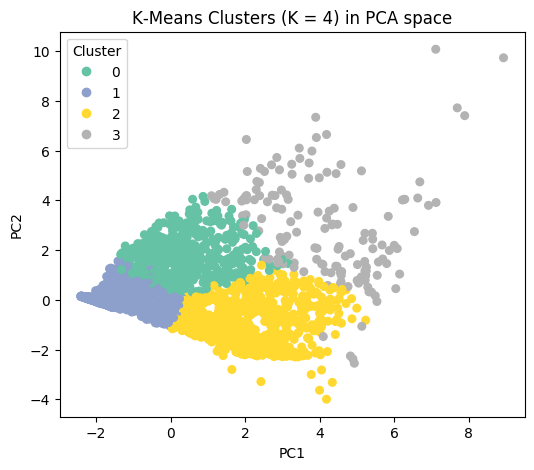

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ----- 1. Elbow & silhouette sweep -----
wcss, sil = [], []
K_range = range(2, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, km.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K_range, wcss, marker="o")
ax[0].set_title("Elbow Curve")
ax[0].set_xlabel("K")
ax[0].set_ylabel("WCSS")

ax[1].plot(K_range, sil, marker="o")
ax[1].set_title("Silhouette Score vs K")
ax[1].set_xlabel("K")
ax[1].set_ylabel("Silhouette")

plt.tight_layout(); plt.show()

# ----- 2. Fit final K (choose from elbow/silhouette) -----
best_k = int(input("Enter chosen K: "))  # or hard‑code after viewing the graph
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_scaled)

# ----- 3. 2‑D PCA scatter -----
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(XY[:, 0], XY[:, 1], c=labels_km, cmap="Set2", s=30)
plt.title(f"K‑Means Clusters (K = {best_k}) in PCA space")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


**Quick notes**

* *Elbow:* Look for the bend where WCSS drops marginally afterwards.  
* *Silhouette:* Peak indicates better cohesion/separation.  
* *Interpretation:* After finalising K, check cluster sizes and means (→ cell below).


In [9]:
# Cluster profiling
km_clusters = pd.concat([id_col, pd.Series(labels_km, name="Cluster")], axis=1)
profile = pd.concat([X, km_clusters["Cluster"]], axis=1).groupby("Cluster").mean()
display(profile.style.format("{:.1f}"))


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll
Cluster,,,,,,,,,,
0,80074.1,0.0,1.4,1.0,1.0,9057.5,10.9,693.1,4.1,4129.4
1,30345.6,0.0,1.3,1.0,1.0,4897.2,6.8,28.7,0.1,2197.0
2,48713.0,0.0,1.5,1.0,1.0,6575.1,8.4,23.4,0.1,5743.5
3,130090.4,0.0,2.8,1.0,1.0,34349.2,33.8,777.5,17.4,4889.2
4,109525.2,0.0,4.1,1.0,1.0,41036.2,19.3,194.1,0.8,4881.7


## 2‑B  Agglomerative (Hierarchical) Clustering

We try the three common linkage criteria (ward, average, complete), visualise a dendrogram, and cut the tree at an appropriate distance.


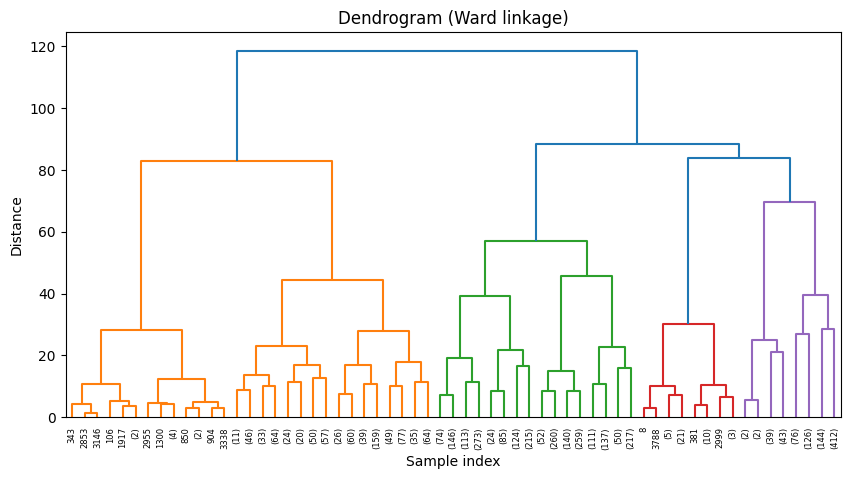

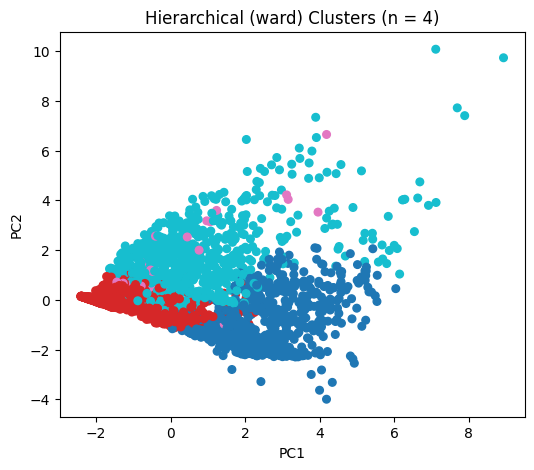

Silhouette: 0.29378551401789554


In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

linkages = ["ward", "average", "complete"]
Z_dict = {lk: linkage(X_scaled, method=lk) for lk in linkages}

# Choose a linkage to inspect
lk = "ward"
plt.figure(figsize=(10, 5))
dendrogram(Z_dict[lk], truncate_mode="level", p=5)
plt.title(f"Dendrogram ({lk.title()} linkage)")
plt.xlabel("Sample index"); plt.ylabel("Distance")
plt.show()

# Decide number of clusters visually or set distance threshold
n_hc = int(input("Cut at how many clusters? "))
hc_labels = fcluster(Z_dict[lk], t=n_hc, criterion="maxclust") - 1  # zero‑index

# PCA scatter
plt.figure(figsize=(6, 5))
plt.scatter(XY[:, 0], XY[:, 1], c=hc_labels, cmap="tab10", s=30)
plt.title(f"Hierarchical ({lk}) Clusters (n = {n_hc})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Silhouette:", silhouette_score(X_scaled, hc_labels))


## 2‑C  DBSCAN

We grid‑search `eps` (neighbourhood radius) and `min_samples` to find a model with meaningful clusters (≥ 2) and acceptable silhouette.


,eps,min_samples,n_clusters,silhouette
10,1.50,5,3,0.568030
49,4.00,4,5,0.567804
47,3.75,6,4,0.565595
51,4.00,6,4,0.565595
45,3.75,4,5,0.564960


Chosen eps=1.50, min_samples=5, clusters=3.0
Silhouette: 0.5680295631544388


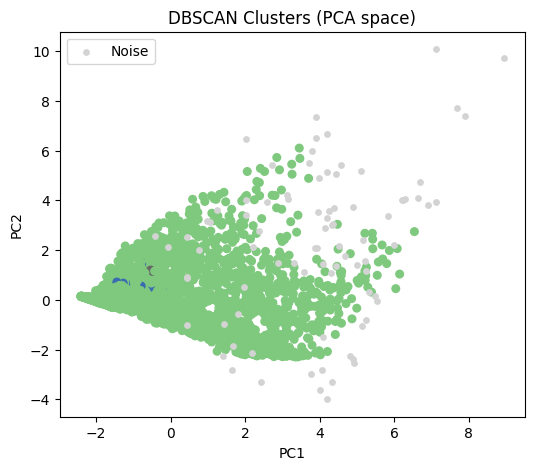

In [12]:
from sklearn.cluster import DBSCAN
import itertools

eps_vals = np.linspace(1.0, 4.0, 13)       # adjust if too coarse/fine
min_samples_vals = [3, 4, 5, 6]
results = []

for eps, ms in itertools.product(eps_vals, min_samples_vals):
    db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
    labels_db = db.labels_
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    if n_clusters >= 2:
        sil = silhouette_score(X_scaled[labels_db != -1], labels_db[labels_db != -1])
        results.append((eps, ms, n_clusters, sil))

res_df = pd.DataFrame(results, columns=["eps", "min_samples", "n_clusters", "silhouette"])
display(res_df.sort_values("silhouette", ascending=False).head())

# Pick the top row
best = res_df.loc[res_df["silhouette"].idxmax()]
db = DBSCAN(eps=best.eps, min_samples=int(best.min_samples)).fit(X_scaled)
labels_db = db.labels_

print(f"Chosen eps={best.eps:.2f}, min_samples={int(best.min_samples)}, clusters={best.n_clusters}")
print("Silhouette:", best.silhouette)

# PCA scatter (ignore noise label -1)
mask = labels_db != -1
plt.figure(figsize=(6, 5))
plt.scatter(XY[mask, 0], XY[mask, 1], c=labels_db[mask], cmap="Accent", s=30)
plt.scatter(XY[~mask, 0], XY[~mask, 1], c="lightgrey", s=15, label="Noise")
plt.title("DBSCAN Clusters (PCA space)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()


### 3‑A: Add Cluster Labels

We merge the K-Means cluster labels back to the original dataset so we can analyze cluster characteristics more clearly.


In [14]:
# Add K-Means cluster labels to the original (scaled) data
df["Cluster"] = labels_km  # from Step 2-A

# Check how many customers per cluster
cluster_counts = df["Cluster"].value_counts().sort_index()
print("Customers per cluster:\n", cluster_counts)

Customers per cluster:
 Cluster
0     559
1    2135
2    1158
3     147
Name: count, dtype: int64


### 3‑B: Summary Statistics by Cluster

We calculate the average of each feature per cluster — this helps reveal patterns in customer behavior or value.


In [15]:
cluster_summary = df.groupby("Cluster").mean(numeric_only=True)
display(cluster_summary.style.format("{:.2f}"))


,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
Cluster,,,,,,,,,,,,
0,2005.44,78711.58,0.00,1.30,1.02,1.00,8445.19,10.41,675.22,3.92,4191.74,0.51
1,2272.43,34571.67,0.00,1.24,1.02,1.00,4405.50,6.71,19.25,0.11,3625.70,0.21
2,1601.66,101811.32,0.00,3.81,1.00,1.02,36354.05,18.41,155.59,0.63,4883.44,0.54
3,1563.67,131312.82,0.00,2.99,1.04,1.14,36754.59,33.61,770.97,15.82,4973.01,0.84


### 3‑C: Box Plots per Feature

We visualize the distribution of each key feature per cluster to understand differences more intuitively.


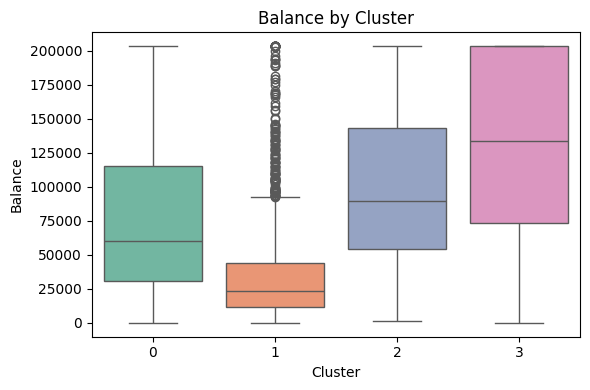

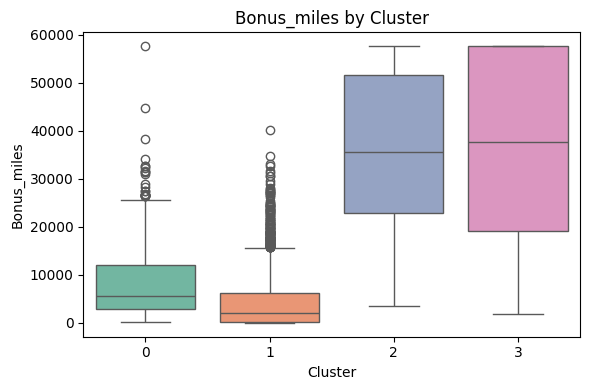

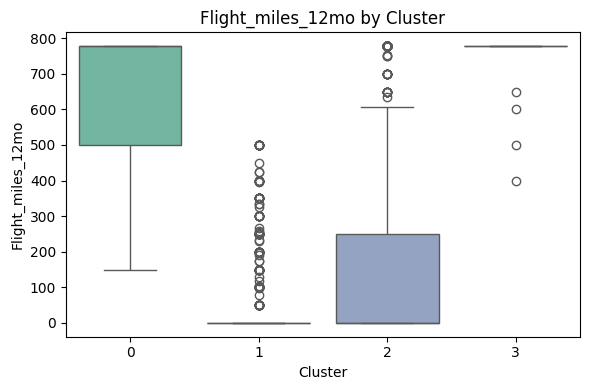

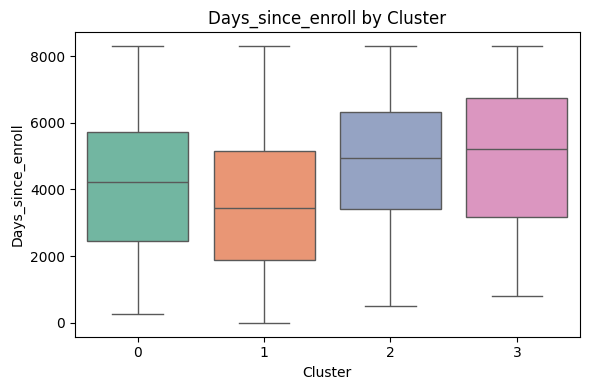

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["Balance", "Bonus_miles", "Flight_miles_12mo", "Days_since_enroll"]

for col in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="Cluster", y=col, hue="Cluster", palette="Set2", legend=False)
    plt.title(f"{col} by Cluster")
    plt.tight_layout()
    plt.show()


### 3‑D: Export to Excel

We save the final dataset with cluster labels to a file for reporting or further analysis.


In [18]:
output_path = "EastWestAirlines_Clustered.xlsx"
df.to_excel(output_path, index=False)
print("File saved as:", output_path)

File saved as: EastWestAirlines_Clustered.xlsx


### 4‑A: Silhouette Score Comparison

We compile silhouette scores from each model to judge overall clustering quality.


In [19]:
from sklearn.metrics import silhouette_score

# Already computed earlier; recomputing here to store for comparison
sil_kmeans = silhouette_score(X_scaled, labels_km)
sil_hc = silhouette_score(X_scaled, hc_labels)
sil_db = silhouette_score(X_scaled[labels_db != -1], labels_db[labels_db != -1])

print("Silhouette Scores:")
print(f"  K-Means (K=4):         {sil_kmeans:.3f}")
print(f"  Hierarchical (Ward):   {sil_hc:.3f}")
print(f"  DBSCAN (excluding noise): {sil_db:.3f}")


Silhouette Scores:
  K-Means (K=4):         0.311
  Hierarchical (Ward):   0.294
  DBSCAN (excluding noise): 0.568


###  Clustering Model Insights (Updated)

- ** DBSCAN** gave the **highest silhouette score (0.568)**, indicating excellent compactness and separation for the dense clusters it discovered — despite ignoring noise points.
- **K-Means** performed fairly well (0.311), indicating moderate separation — good for well-behaved, spherical clusters.
- **Hierarchical Clustering (Ward)** was close behind K-Means, scoring 0.294 — interpretable but with slightly less clear boundaries.

###  Recommendation:

- If your goal is **tight, natural clusters and outlier detection** → **choose DBSCAN**.
- If you want **clean segmentation with all points assigned** and easier business interpretation → **K-Means (K=4)** remains a solid choice.
